In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, f1_score, log_loss, matthews_corrcoef
%matplotlib inline
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from xgboost import XGBClassifier

## Stock Predictor

In [2]:
from yahoo_historical import Fetcher

In [3]:
df = Fetcher('SMGR.JK',[2010,1,1],[2019,1,1]).getHistorical()

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7600.0,7650.0,7500.0,7600.0,5834.542969,3979000.0
1,2010-01-05,7700.0,7750.0,7650.0,7700.0,5911.312988,5844500.0
2,2010-01-06,7800.0,7950.0,7700.0,7800.0,5988.083008,4945000.0
3,2010-01-07,7700.0,7950.0,7600.0,7700.0,5911.312988,3886000.0
4,2010-01-08,7650.0,7750.0,7600.0,7650.0,5872.927246,9397500.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 7 columns):
Date         2233 non-null object
Open         2224 non-null float64
High         2224 non-null float64
Low          2224 non-null float64
Close        2224 non-null float64
Adj Close    2224 non-null float64
Volume       2224 non-null float64
dtypes: float64(6), object(1)
memory usage: 122.2+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2224.000000,2224.000000,2224.000000,2224.000000,2224.000000,2.224000e+03
mean,11429.249101,11567.367356,11273.223921,11422.380845,9989.369743,6.981357e+06
std,2849.986966,2872.692198,2822.636829,2844.977986,2456.139681,5.430919e+06
min,6725.000000,6950.000000,6500.000000,6725.000000,5604.231934,0.000000e+00
25%,9225.000000,9325.000000,9075.000000,9218.750000,8146.754394,3.899150e+06
50%,10437.500000,10575.000000,10300.000000,10450.000000,9574.803711,5.751350e+06
75%,13800.000000,14000.000000,13562.500000,13800.000000,11947.580811,8.597425e+06
max,19000.000000,19150.000000,18800.000000,19000.000000,15924.331055,7.413070e+07


### 1. Delete all unnecessary variables

In [7]:
df.drop(['Open','Close'], axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

### 2. Change the value of  "0" to NaN and delete it

In [8]:
df.replace(0, np.nan, inplace=True)

In [9]:
df.dropna(inplace = True)

In [10]:
df.head()

,Date,High,Low,Adj Close,Volume
0,2010-01-04,7650.0,7500.0,5834.542969,3979000.0
1,2010-01-05,7750.0,7650.0,5911.312988,5844500.0
2,2010-01-06,7950.0,7700.0,5988.083008,4945000.0
3,2010-01-07,7950.0,7600.0,5911.312988,3886000.0
4,2010-01-08,7750.0,7600.0,5872.927246,9397500.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2230
Data columns (total 5 columns):
Date         2172 non-null datetime64[ns]
High         2172 non-null float64
Low          2172 non-null float64
Adj Close    2172 non-null float64
Volume       2172 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 101.8 KB


### 3. Making Variables

####  3.1 Simple Moving Average

In [13]:
##Simple Moving Average

ma = []
for i in range(len(df)):
    if i < 14:
        ma.append(np.nan)
    else:
        ma.append(df['Adj Close'][(i-14):i].mean())
df['SMA'] = ma
        

####  3.2 Bollinger Bands

In [14]:
## Bollinger Bands ( Lower )

BBLower = []
for i in range(len(df)):
    if i < 14 :
        BBLower.append(np.nan)
    else:
        BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
df['BBLower'] = BBLower

#### 3.3 Result (Dependent Variable)

In [15]:
result = []
for i in range(len(df)):
    if i < 14:
        result.append(np.nan)
    elif i > (len(df)-15):
        result.append(np.nan)
    else:
        if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
            result.append('Profit')
        else:
            result.append('Loss')
df['Result'] = result

In [16]:
df

,Date,High,Low,Adj Close,Volume,SMA,BBLower,Result
0,2010-01-04,7650.0,7500.0,5834.542969,3979000.0,NaN,NaN,NaN
1,2010-01-05,7750.0,7650.0,5911.312988,5844500.0,NaN,NaN,NaN
2,2010-01-06,7950.0,7700.0,5988.083008,4945000.0,NaN,NaN,NaN
3,2010-01-07,7950.0,7600.0,5911.312988,3886000.0,NaN,NaN,NaN
4,2010-01-08,7750.0,7600.0,5872.927246,9397500.0,NaN,NaN,NaN
5,2010-01-11,7850.0,7650.0,5949.698242,9217000.0,NaN,NaN,NaN
6,2010-01-12,7850.0,7650.0,5949.698242,2723000.0,NaN,NaN,NaN
7,2010-01-13,7950.0,7650.0,5911.312988,6713500.0,NaN,NaN,NaN
8,2010-01-14,7850.0,7700.0,5949.698242,4721000.0,NaN,NaN,NaN
9,2010-01-15,7850.0,7700.0,5988.083008,4423000.0,NaN,NaN,NaN


### Deleting all NaN data

In [17]:
df.dropna(axis = 0, inplace = True)

In [18]:
df.head()

,Date,High,Low,Adj Close,Volume,SMA,BBLower,Result
14,2010-01-22,8200.0,7800.0,6218.395020,6151000.0,5960.665248,5802.963108,Loss
15,2010-01-25,8100.0,7900.0,6103.238281,2309500.0,5988.083252,5795.273473,Loss
16,2010-01-26,8050.0,7900.0,6064.853027,3323000.0,6001.792201,5805.239880,Loss
17,2010-01-27,7950.0,7700.0,5988.083008,3832000.0,6007.275774,5808.104877,Profit
18,2010-01-28,8100.0,7800.0,6218.395020,3956000.0,6012.759347,5820.875622,Loss


In [19]:
dfprofit = []
for i in range(len(df)):
    if df['Result'].iloc[i] == 'Profit':
        dfprofit.append(df.iloc[i])
pd.DataFrame(dfprofit)

,Date,High,Low,Adj Close,Volume,SMA,BBLower,Result
17,2010-01-27,7950.0,7700.0,5988.083008,3832000.0,6007.275774,5808.104877,Profit
24,2010-02-05,7700.0,7500.0,5796.157227,7933000.0,6078.562395,5917.507096,Profit
25,2010-02-08,7650.0,7250.0,5796.157227,4395500.0,6067.595180,5855.815961,Profit
34,2010-02-19,7750.0,7600.0,5872.927246,3196500.0,5988.083112,5815.103986,Profit
35,2010-02-22,7700.0,7500.0,5834.542969,5409000.0,5974.374128,5797.232789,Profit
36,2010-02-23,7650.0,7400.0,5872.927246,5917000.0,5957.923410,5774.318917,Profit
37,2010-02-24,7650.0,7500.0,5834.542969,1650000.0,5944.214425,5766.434286,Profit
38,2010-02-25,7700.0,7500.0,5834.542969,3309000.0,5933.247280,5748.324628,Profit
41,2010-03-03,7600.0,7450.0,5719.387695,5937000.0,5930.505546,5760.834112,Profit
42,2010-03-04,7550.0,7450.0,5719.387695,3179000.0,5908.571184,5714.673139,Profit


In [20]:
df[df['Result'] == 'Loss']

,Date,High,Low,Adj Close,Volume,SMA,BBLower,Result
14,2010-01-22,8200.0,7800.0,6218.395020,6151000.0,5960.665248,5802.963108,Loss
15,2010-01-25,8100.0,7900.0,6103.238281,2309500.0,5988.083252,5795.273473,Loss
16,2010-01-26,8050.0,7900.0,6064.853027,3323000.0,6001.792201,5805.239880,Loss
18,2010-01-28,8100.0,7800.0,6218.395020,3956000.0,6012.759347,5820.875622,Loss
19,2010-01-29,8000.0,7850.0,6141.623535,3115500.0,6037.435617,5834.479698,Loss
20,2010-02-01,8000.0,7750.0,6064.853027,3701500.0,6051.144566,5847.790179,Loss
21,2010-02-02,7950.0,7850.0,6064.853027,2875500.0,6059.369908,5864.555085,Loss
22,2010-02-03,8000.0,7850.0,6064.853027,2147000.0,6070.337054,5895.125562,Loss
23,2010-02-04,7900.0,7750.0,5988.083008,6399000.0,6078.562395,5917.507096,Loss
26,2010-02-09,7850.0,7400.0,5988.083008,4280000.0,6051.144357,5794.561914,Loss


# EDA

In [21]:
df.set_index('Date', inplace=True)

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


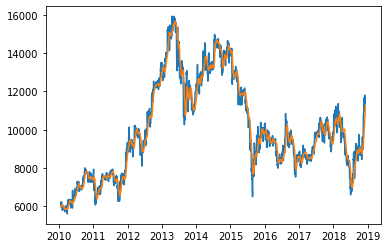

In [22]:
plt.plot(df['Adj Close'])
plt.plot(df['SMA'])

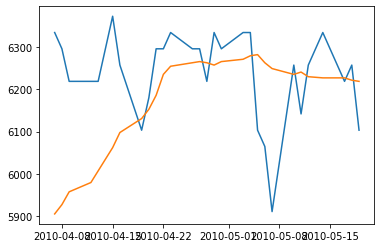

In [23]:
plt.plot(df['Adj Close'][50:80])
plt.plot(df['SMA'][50:80])

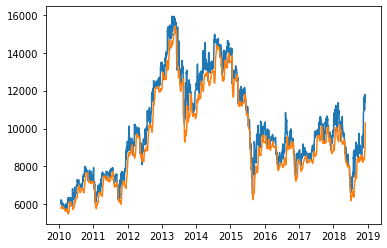

In [24]:
plt.plot(df['Adj Close'])
plt.plot(df['BBLower'])

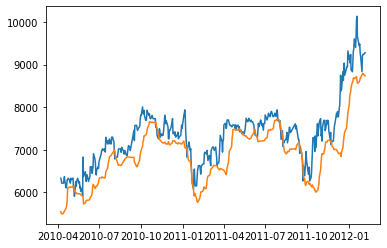

In [25]:
plt.plot(df['Adj Close'][50:500])
plt.plot(df['BBLower'][50:500])

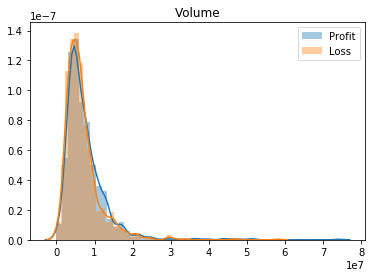

In [26]:
cp1 = []
cp0 = []
cp2 = []
cp3 = []
cp4 = []
cp5 = []
for i in range(len(df)):
    if df['Result'].iloc[i] == 'Profit' :
        cp4.append(df['Volume'].iloc[i])
    elif df['Result'].iloc[i] == 'Loss' :
        cp5.append(df['Volume'].iloc[i])
sns.distplot( cp4 , label="Profit").set_title('Volume')
sns.distplot( cp5 , label="Loss")
plt.legend()
plt.show()

In [27]:
df.head()

,High,Low,Adj Close,Volume,SMA,BBLower,Result
Date,,,,,,,
2010-01-22,8200.0,7800.0,6218.395020,6151000.0,5960.665248,5802.963108,Loss
2010-01-25,8100.0,7900.0,6103.238281,2309500.0,5988.083252,5795.273473,Loss
2010-01-26,8050.0,7900.0,6064.853027,3323000.0,6001.792201,5805.239880,Loss
2010-01-27,7950.0,7700.0,5988.083008,3832000.0,6007.275774,5808.104877,Profit
2010-01-28,8100.0,7800.0,6218.395020,3956000.0,6012.759347,5820.875622,Loss


In [28]:
df.reset_index(inplace=True)

In [29]:
data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
result = df['Result']

## Random Forest

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
predictions = rfc.predict(X_test)
print(confusion_matrix(y_test,predictions))

[[134  73]
 [ 61 161]]


In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        Loss       0.69      0.65      0.67       207
      Profit       0.69      0.73      0.71       222

    accuracy                           0.69       429
   macro avg       0.69      0.69      0.69       429
weighted avg       0.69      0.69      0.69       429



In [34]:
print(classification_report(y_train,rfc.predict(X_train)))

              precision    recall  f1-score   support

        Loss       1.00      1.00      1.00       811
      Profit       1.00      1.00      1.00       904

    accuracy                           1.00      1715
   macro avg       1.00      1.00      1.00      1715
weighted avg       1.00      1.00      1.00      1715



### XGBoost

In [35]:
from xgboost import XGBClassifier

In [36]:
xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)

In [37]:
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
print(classification_report(y_test, xgboost.predict(X_test)))

              precision    recall  f1-score   support

        Loss       0.69      0.62      0.65       207
      Profit       0.67      0.74      0.71       222

    accuracy                           0.68       429
   macro avg       0.68      0.68      0.68       429
weighted avg       0.68      0.68      0.68       429



In [39]:
print(classification_report(y_train, xgboost.predict(X_train)))

              precision    recall  f1-score   support

        Loss       0.81      0.76      0.79       811
      Profit       0.80      0.84      0.82       904

    accuracy                           0.80      1715
   macro avg       0.81      0.80      0.80      1715
weighted avg       0.81      0.80      0.80      1715



In [40]:
data = classification_report(y_test, xgboost.predict(X_test))

In [41]:
pd.DataFrame(confusion_matrix(y_test,xgboost.predict(X_test)), columns = ['P Loss', 'P Profit'], index = ['A Loss', 'A Profit'])

,P Loss,P Profit
A Loss,128,79
A Profit,58,164


In [42]:
xgboost.predict_proba(X_test)

array([[0.38358527, 0.6164147 ],
       [0.35070723, 0.64929277],
       [0.37106168, 0.6289383 ],
       [0.3778742 , 0.6221258 ],
       [0.4055618 , 0.5944382 ],
       [0.37808532, 0.6219147 ],
       [0.65876234, 0.3412377 ],
       [0.42155266, 0.57844734],
       [0.30331564, 0.69668436],
       [0.72300696, 0.276993  ],
       [0.7884004 , 0.21159957],
       [0.37415272, 0.6258473 ],
       [0.5283838 , 0.4716162 ],
       [0.08943355, 0.91056645],
       [0.4032516 , 0.5967484 ],
       [0.52756196, 0.47243804],
       [0.4535643 , 0.5464357 ],
       [0.2524987 , 0.7475013 ],
       [0.5139384 , 0.48606157],
       [0.5977309 , 0.40226915],
       [0.74309695, 0.25690302],
       [0.14534658, 0.8546534 ],
       [0.11609936, 0.88390064],
       [0.71752286, 0.28247714],
       [0.35281986, 0.64718014],
       [0.30657446, 0.69342554],
       [0.18137622, 0.8186238 ],
       [0.8101916 , 0.18980843],
       [0.63876617, 0.36123386],
       [0.71360815, 0.28639188],
       [0.

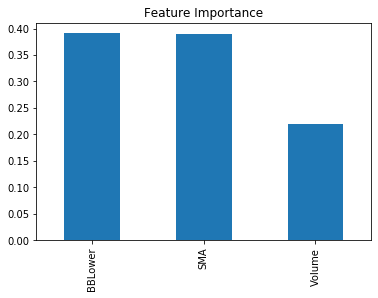

In [43]:
coef1 = pd.Series(xgboost.feature_importances_, X_train.columns).sort_values(ascending = False)
coef1.plot(kind = 'bar', title = 'Feature Importance')

In [44]:
accuracy_score(y_test,xgboost.predict(X_test))

0.6806526806526807

In [46]:
from sklearn.model_selection import GridSearchCV

param_learning = (0.12, 0.1, 0.08, 0.06)
param_estimator = (80,100,120,140)
param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator}

gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6839650145772594
{'learning_rate': 0.12, 'n_estimators': 80}


In [49]:
xgboost = XGBClassifier(learning_rate = 0.12, n_estimators = 80, max_depth = 4)
xgboost.fit(X_train, y_train)
print(classification_report(y_test, xgboost.predict(X_test)))

              precision    recall  f1-score   support

        Loss       0.70      0.62      0.66       207
      Profit       0.68      0.76      0.72       222

    accuracy                           0.69       429
   macro avg       0.69      0.69      0.69       429
weighted avg       0.69      0.69      0.69       429



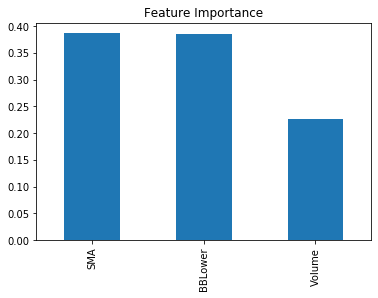

In [50]:
coef1 = pd.Series(xgboost.feature_importances_, X_train.columns).sort_values(ascending = False)
coef1.plot(kind = 'bar', title = 'Feature Importance')

### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
predictions = logmodel.predict(X_test)

In [54]:
pd.DataFrame(confusion_matrix(y_test,predictions), columns = ['P No', 'P Yes'], index = ['A No', 'A Yes'])

,P No,P Yes
A No,89,118
A Yes,76,146


In [55]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        Loss       0.54      0.43      0.48       207
      Profit       0.55      0.66      0.60       222

    accuracy                           0.55       429
   macro avg       0.55      0.54      0.54       429
weighted avg       0.55      0.55      0.54       429



In [56]:
print(classification_report(y_train,logmodel.predict(X_train)))

              precision    recall  f1-score   support

        Loss       0.53      0.46      0.49       811
      Profit       0.56      0.62      0.59       904

    accuracy                           0.55      1715
   macro avg       0.54      0.54      0.54      1715
weighted avg       0.55      0.55      0.55      1715



### KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
result = df['Result']

In [60]:
scaler = StandardScaler()

In [61]:
scaler.fit(data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [62]:
scaled_features = scaler.transform(data)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)

In [64]:
knn = KNeighborsClassifier(n_neighbors=2)

In [65]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [66]:
pred = knn.predict(X_test)

In [67]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

        Loss       0.45      0.74      0.56       192
      Profit       0.56      0.27      0.36       237

    accuracy                           0.48       429
   macro avg       0.51      0.51      0.46       429
weighted avg       0.51      0.48      0.45       429



In [68]:
print(classification_report(y_train,knn.predict(X_train)))

              precision    recall  f1-score   support

        Loss       0.65      1.00      0.79       826
      Profit       1.00      0.51      0.67       889

    accuracy                           0.75      1715
   macro avg       0.83      0.75      0.73      1715
weighted avg       0.83      0.75      0.73      1715



### "Hypertuning Variable"

In [69]:
def accuracyyy(stock):
    accuracies = []
    for n in range(1,31):
        df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
        df.drop(['Open','Close'], axis = 1, inplace = True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.replace(0, np.nan, inplace=True)
        df.dropna(inplace = True)
        ma = []
        for i in range(len(df)):
            if i < 14:
                ma.append(np.nan)
            else:
                ma.append(df['Adj Close'][(i-14):i].mean())
        df['SMA'] = ma
        BBLower = []
        for i in range(len(df)):
            if i < 14 :
                BBLower.append(np.nan)
            else:
                BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
        df['BBLower'] = BBLower
        williamsr= []
        for i in range(len(df)):
            if i < 14 :
                williamsr.append(np.nan)
            else:
                high = df['High'].iloc[(i-14):(i)].max()
                low = df['Low'].iloc[(i-14):(i)].min()
                williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
        df['Williams R'] = williamsr
        result = []
        for i in range(len(df)):
            if i < n:
                result.append(np.nan)
            elif i > (len(df)-(n+1)):
                result.append(np.nan)
            else:
                if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+n]:
                    result.append('Profit')
                else:
                    result.append('Loss')
        df['Result'] = result
        df.dropna(axis = 0, inplace = True)
        data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
        result = df['Result']
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
        xgboost.fit(X_train, y_train)
        param_learning = (0.12, 0.1, 0.08, 0.06)
        param_estimator = (80,100,120,140)
        max_depth = (1,2,3,4)
        param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
        gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
        gs = gs.fit(X_train, y_train)
        learning_rates = 0
        n_estimatorss = 0
        max_depths = 0
        learning_rates += gs.best_params_['learning_rate']
        n_estimatorss += gs.best_params_['n_estimators']
        max_depths += gs.best_params_['max_depth']
        xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
        xgboost.fit(X_train, y_train)
        predictions = xgboost.predict(X_test)
        accuracies.append(accuracy_score(y_test,predictions))
    data = pd.DataFrame(accuracies)
    return data

In [70]:
angka = pd.DataFrame(accuracyyy('SMGR.JK'))
angka

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

,0
0,0.523148
1,0.550926
2,0.542923
3,0.603248
4,0.631090
5,0.677494
6,0.677494
7,0.688372
8,0.662791
9,0.697674


In [63]:
pd.DataFrame(angka[0].sort_values(ascending = False))

,0
27,0.759434
23,0.757647
24,0.741176
29,0.737589
17,0.735981
22,0.734742
28,0.732861
16,0.724299
19,0.721311
21,0.718310


In [71]:
bestresult = (angka[0].sort_values(ascending = False).reset_index()['index'][0] + 1)
bestresult

30

### Input the best result on the algorithm

In [72]:
        df = Fetcher('SMGR.JK',[2010,1,1],[2019,1,1]).getHistorical()
        df.drop(['Open','Close'], axis = 1, inplace = True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.replace(0, np.nan, inplace=True)
        df.dropna(inplace = True)
        ma = []
        for i in range(len(df)):
            if i < 14:
                ma.append(np.nan)
            else:
                ma.append(df['Adj Close'][(i-14):i].mean())
        df['SMA'] = ma
        BBLower = []
        for i in range(len(df)):
            if i < 14 :
                BBLower.append(np.nan)
            else:
                BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
        df['BBLower'] = BBLower
        williamsr= []
        for i in range(len(df)):
            if i < 14 :
                williamsr.append(np.nan)
            else:
                high = df['High'].iloc[(i-14):(i)].max()
                low = df['Low'].iloc[(i-14):(i)].min()
                williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
        df['Williams R'] = williamsr
        result = []
        for i in range(len(df)):
            if i < bestresult:
                result.append(np.nan)
            elif i > (len(df)-(bestresult+1)):
                result.append(np.nan)
            else:
                if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+bestresult]:
                    result.append('Profit')
                else:
                    result.append('Loss')
        df['Result'] = result
        df.dropna(axis = 0, inplace = True)
        data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
        result = df['Result']
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
        xgboost.fit(X_train, y_train)
        param_learning = (0.12, 0.1, 0.08, 0.06)
        param_estimator = (80,100,120,140)
        max_depth = (1,2,3,4)
        param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
        gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
        gs = gs.fit(X_train, y_train)
        learning_rates = 0
        n_estimatorss = 0
        max_depths = 0
        learning_rates += gs.best_params_['learning_rate']
        n_estimatorss += gs.best_params_['n_estimators']
        max_depths += gs.best_params_['max_depth']
        xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
        xgboost.fit(X_train, y_train)
        predictions = xgboost.predict(X_test)
        print(classification_report(y_test,predictions))
        

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

        Loss       0.75      0.64      0.69       185
      Profit       0.75      0.84      0.79       238

    accuracy                           0.75       423
   macro avg       0.75      0.74      0.74       423
weighted avg       0.75      0.75      0.75       423



### Final Code

In [73]:
def modelnextlevel(stock):
    df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
    df.drop(['Open','Close'], axis = 1, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.replace(0, np.nan, inplace=True)
    df.dropna(inplace = True)
    ma = []
    for i in range(len(df)):
        if i < 14:
            ma.append(np.nan)
        else:
            ma.append(df['Adj Close'][(i-14):i].mean())
    df['SMA'] = ma
    BBLower = []
    for i in range(len(df)):
        if i < 14 :
            BBLower.append(np.nan)
        else:
            BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
    df['BBLower'] = BBLower
    result = []
    for i in range(len(df)):
        if i < 14:
            result.append(np.nan)
        elif i > (len(df)-15):
            result.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
                result.append('Profit')
            else:
                result.append('Loss')
    df['Result'] = result
    df.dropna(axis = 0, inplace = True)
    data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
    result = df['Result']
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2, random_state = 100)
    xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
    xgboost.fit(X_train, y_train)
    param_learning = (0.12, 0.1, 0.08, 0.06)
    param_estimator = (80,100,120,140)
    max_depth = (1,2,3,4)
    param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
    gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
    gs = gs.fit(X_train, y_train)
    learning_rates = 0
    n_estimatorss = 0
    max_depths = 0
    learning_rates += gs.best_params_['learning_rate']
    n_estimatorss += gs.best_params_['n_estimators']
    max_depths += gs.best_params_['max_depth']
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    angka = 0
    accuracies = []
    for n in range(1,31):
        result = []
        for i in range(len(df)):
            if i < n:
                result.append(np.nan)
            elif i > (len(df)-(n+1)):
                result.append(np.nan)
            else:
                if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+n]:
                    result.append('Profit')
                else:
                    result.append('Loss')
        df['Result'] = result
        df.dropna(axis = 0, inplace = True)
        data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
        result = df['Result']
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2, random_state = 100)
        xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
        xgboost.fit(X_train, y_train)
        predictions = xgboost.predict(X_test)
        accuracies.append(accuracy_score(y_test,predictions))
    angkas = pd.DataFrame(accuracies)
    bestresult = (angkas[0].sort_values(ascending = False).reset_index()['index'][0] + 1)
    angka += bestresult
    accuracies = []  
    predictions = xgboost.predict(X_test)
    resultnew = []
    for i in range(len(df)):
        if i <  angka:
            resultnew.append(np.nan)
        elif i > (len(df)-(angka + 1)):
            resultnew.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+angka]:
                resultnew.append('Profit')
            else:
                resultnew.append('Loss')
    df['Result'] = resultnew
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    dfpredict = Fetcher(stock,[2019,10,8],[2019,11,18]).getHistorical()
    dfpredict = dfpredict[['Volume','Adj Close']]
    dfpredict['SMA'] = dfpredict['Adj Close'][-angka:-1].mean()
    dfpredict['BBLower'] = df['SMA'].iloc[-1] - (2 * df['Adj Close'][-angka:].std())
    dfpredict.drop('Adj Close', axis =1, inplace = True)
    df2 = []
    if xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0] == 'Loss':
          df2.append([stock,
                xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0],
                pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[-1]).transpose()))[0][0],
                accuracy_score(y_test,predictions),angka])
    elif xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0] == 'Profit':
          df2.append([stock,
                xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0],
                pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[-1]).transpose()))[1][0],
                accuracy_score(y_test,predictions),angka])
    return df2

###  Put your stocks code that you want to see the recommendation

In [74]:
df3 = []

stocks = ['SMGR.JK']
for i in range(len(stocks)):
    df3.append(modelnextlevel(stocks[i])[0])
pd.DataFrame(df3, columns = ['Stocks', 'Prediction', 'Probability', 'Accuracy', 'Best Time'])

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


,Stocks,Prediction,Probability,Accuracy,Best Time
0,SMGR.JK,Profit,0.56916,0.72428,28
